# Acceleration Window Comparison - H2O

### Imports

In [78]:
# Close pre-existing cluster
h2o.cluster().shutdown()

H2O session _sid_8032 closed.


In [80]:
import h2o
from h2o.estimators import H2ODeepLearningEstimator
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt

# Initialise new cluster
h2o.init(min_mem_size="30G", max_mem_size="100G", nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "11.0.11" 2021-04-20 LTS; Java(TM) SE Runtime Environment 18.9 (build 11.0.11+9-LTS-194); Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.11+9-LTS-194, mixed mode)
  Starting server from /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/cq/f3s5lbpx2d5b0qtp8476t3yh0000gn/T/tmp6f61uz4s
  JVM stdout: /var/folders/cq/f3s5lbpx2d5b0qtp8476t3yh0000gn/T/tmp6f61uz4s/h2o_alexzamar_started_from_python.out
  JVM stderr: /var/folders/cq/f3s5lbpx2d5b0qtp8476t3yh0000gn/T/tmp6f61uz4s/h2o_alexzamar_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,1 month and 20 days
H2O_cluster_name:,H2O_from_python_alexzamar_r2ignr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,100 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


### Build, train, and cross-validate models

In [66]:
files = glob.glob('../Data/Reduced/ACC2*.csv')
dt = 'ACC'

#files = glob.glob('../Data/Reduced/IMM600*.csv')
#dt = 'IMM'

f =files[0]

In [67]:
data = h2o.import_file(f, header=1)
data['Dive'] = data['Dive'].asfactor()
data['BirdID'] = data['BirdID'].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [60]:
pandas_data = data.as_data_frame()
pandas_data.shape

(190005, 152)

In [61]:
pandas_data_reduced = pandas_data.groupby(['BirdID']).apply(lambda grp: grp.sample(n=5000)).reset_index(level=[0, 1], drop=True)
data = h2o.H2OFrame(pandas_data_reduced)
data['Dive'] = data['Dive'].asfactor()
data['BirdID'] = data['BirdID'].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [54]:
data.shape

(190005, 152)

In [68]:
# Extract model ID from filepath
#wdw = re.search(fr"/{dt}(\d+)_reduced", f).group(1)
#idd = 'ACC_window_' + wdw

# Build and train the model:
dl_cross = H2ODeepLearningEstimator(distribution = "bernoulli",
                                    hidden = [200, 200],
                                    fold_column = 'BirdID',
                                    keep_cross_validation_models = True,
                                    keep_cross_validation_fold_assignment = True,
                                    keep_cross_validation_predictions = True,
                                    score_each_iteration = True,
                                    epochs = 50,
                                    train_samples_per_iteration = -1,
                                    activation = "RectifierWithDropout",
                                    input_dropout_ratio = 0.2,
                                    hidden_dropout_ratios = [0.2, 0.2],
                                    single_node_mode = False,
                                    balance_classes = False,
                                    force_load_balance = False,
                                    seed = 23123,
                                    score_training_samples = 0,
                                    score_validation_samples = 0,
                                    stopping_rounds = 0,
                                    standardize=True)

dl_cross.train(x = data.columns[1:-1],
               y="Dive",
               training_frame=data)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [69]:
dl_cross.cross_validation_metrics_summary()


Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid
0,accuracy,0.981662,0.0040785503,0.9792062,0.9889087,0.97648335,0.9829384,0.9802403,0.9859375,0.97671044,0.9817499,0.98278296
1,auc,0.99655366,0.0014215999,0.99470264,0.9990519,0.9965472,0.99618864,0.99584764,0.99783444,0.9947938,0.9964097,0.99760705
2,err,0.018338034,0.0040785503,0.02079379,0.011091305,0.023516653,0.017061612,0.019759713,0.0140625,0.023289569,0.018250115,0.017217048
3,err_count,409.77777,236.71913,734.0,56.0,759.0,270.0,324.0,189.0,353.0,515.0,488.0
4,f0point5,0.97750723,0.0036669946,0.97610694,0.9837488,0.9753718,0.9785584,0.974211,0.980276,0.9715729,0.9775207,0.9801986
5,f1,0.98121214,0.004383451,0.9786305,0.9888977,0.9753147,0.9828179,0.9798181,0.985926,0.976176,0.9810766,0.98225194
6,f2,0.9849519,0.0056928103,0.9811671,0.99410075,0.9752576,0.9871146,0.9854902,0.99164146,0.980823,0.9846585,0.98431396
7,lift_top_group,2.0569983,0.02824319,2.064269,2.0196,2.099187,2.0288463,2.0625157,2.0210526,2.062177,2.0864325,2.068905
8,logloss,0.06603291,0.015523832,0.08073749,0.03661266,0.07833933,0.063862726,0.07494155,0.050664987,0.08237064,0.070220165,0.05654661
9,max_per_class_error,0.024160445,0.0034075351,0.0242321,0.019615535,0.024780488,0.023925234,0.02829407,0.02341679,0.030101191,0.023138696,0.019939907


In [ ]:
files = glob.glob('../Data/Reduced/ACC*.csv')

for f in files:
    # Iitialise new cluster
    #h2o.init(min_mem_size="30G", max_mem_size="100G", nthreads = -1)
    
    print(f'PROCESSING FILE: {f}')
    
    # Load data
    data = h2o.import_file(f, header=1)
    data['Dive'] = data['Dive'].asfactor()
    data['BirdID'] = data['BirdID'].asfactor()
    
    # Extract model ID from filepath
    wdw = re.search(r"/ACC(\d+)_reduced", f).group(1)
    idd = 'ACC_window_' + wdw + '_model'
    
    # Build and train the model:
    dl_cross = H2ODeepLearningEstimator(model_id = idd,
                                        distribution = "bernoulli",
                                        hidden = [200, 200],
                                        fold_column = 'BirdID',
                                        keep_cross_validation_models = True,
                                        keep_cross_validation_fold_assignment = True,
                                        keep_cross_validation_predictions = True,
                                        score_each_iteration = True,
                                        epochs = 50,
                                        train_samples_per_iteration = -1,
                                        activation = "RectifierWithDropout",
                                        #input_dropout_ratio = 0.2,
                                        hidden_dropout_ratios = [0.2, 0.2],
                                        single_node_mode = False,
                                        balance_classes = False,
                                        force_load_balance = False,
                                        seed = 23123,
                                        score_training_samples = 0,
                                        score_validation_samples = 0,
                                        stopping_rounds = 0,
                                        standardize=True)

    dl_cross.train(x = data.columns[1:-1],
                   y="Dive",
                   training_frame=data)
    
    # Save model
    print('Saving...')
    #h2o.save_model(model=dl_cross, path="../Results/Reduced/H2O_ACC_XVal_Models/", force=True)
    h2o.save_model(model=dl_cross, path="/Volumes/Samsung_T5/Seabird_Data/Results/H2O_ACC_XVal_Models/", force=True)

    # Close cluster
    #h2o.cluster().shutdown()

PROCESSING FILE: ../Data/Reduced/ACC2_reduced_all_dives.csv
Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████

### Evaluate models

In [215]:
# Retrieve file paths
models = glob.glob('../Data/Reduced/H2O_ACC_XVal_Models/*')
all_mets = pd.DataFrame(columns=['Accuracy', 'AUC', 'Sensitivity', 'Specificity'])

for mod_pth in models:
    
    wdw = re.match('.*?([0-9]+)$', mod_pth).group(1)  # window size
    
    #print(f'PROCESSING MODEL: {mod_pth}...')
    model = h2o.load_model(mod_pth)
    
    # Pull out X-validation metrics
    metrics = model.cross_validation_metrics_summary().as_data_frame()
    metrics.set_index('', inplace=True)
    metrics = metrics.astype(float)
    
    accuracy = metrics['mean']['accuracy']
    auc = metrics['mean']['auc']
    sensitivity = metrics['mean']['recall']
    specificity = metrics['mean']['specificity']
    
    all_mets.loc[wdw] = [accuracy, auc, sensitivity, specificity]

# Sort and show data
all_mets.sort_index(ascending=True, axis=0, inplace=True)
all_mets

,Accuracy,AUC,Sensitivity,Specificity
120,0.899045,0.928940,0.904088,0.894647
180,0.912163,0.948984,0.945191,0.880581
240,0.920811,0.956735,0.945910,0.896549
300,0.924332,0.963748,0.958844,0.890825
480,0.920994,0.962822,0.971331,0.874496
600,0.923452,0.959010,0.970020,0.878939


### Plot

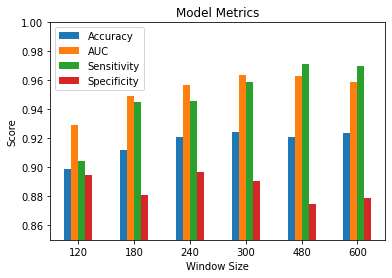

In [213]:
all_mets.plot.bar()

# Furnish plot
plt.xlabel("Window Size")
plt.xticks(rotation=0)
plt.ylabel("Score")
plt.ylim([0.85, 1.0])
plt.title('Model Metrics')

plt.show()

**CONCLUSION:** A window size of 300s (5 mins) attained the highest accuracy and AUC scores predicting dives from immersion data (0.924 and 0.964 respectively)